In [1]:
import sys
sys.path.append("vendor/cyberML")

%matplotlib widget
import matplotlib.pyplot as plt

from enbed.utils.batcher import batch_provider
from enbed.utils import conv
from enbed.models import RESCAL, Energy, EnergyDiag
from enbed.training import train_RESCAL, train_energy

import numpy as np
import os
import seaborn as sns
import torch

In [2]:
def get_scores(model, triples):
    return model.prob(triples[:,0], triples[:,1], triples[:,2]).detach().numpy()

def draw_plot(model, model_name):
    fig = plt.figure()
    colors = ["#D62828","#FF931F","#6D3764","#007CBE", 'k']
    markers = ['1', 'x', '.', '+', '*']
    
    triples, triples_named, labels = conv.load_test('{}/test'.format(path), 'test')
    scores = get_scores(model, triples)
    labs, scs= [], []
    train_sc = []
    
    for i in range(len(triples_named)):
        if labels[i] == 4:
            train_sc.append(scores[i])
        else:
            labs.append(labels[i])
            scs.append(scores[i])
            
    labs.append(4)
    scs.append(np.mean(train_sc))
    labs = np.array(labs)
    scs = np.array(scs)


    x0 = 0
    totallen = 0    
    for i in range(5):
        totallen += len(scs[labs==i])
    for i in range(5):
        if i in labs:
            s1 = scs[labs==i]
            xran = np.arange(x0, x0+len(s1))
            idorder = np.argsort(s1)
            marker = markers[i]
            msize = 7
            color = colors[i]
            plt.plot(xran, s1[idorder], marker = marker, markersize=msize, linewidth=0, color = color)
            x0 += len(s1)+0.065*totallen
            
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xticks([])
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    plt.title(f"{model_name} Triple Statement Probabilities")
    plt.ylabel("$p_{s,r,o}$")
    plt.xlabel("Triple Statements")
    plt.show()

## Train the model on the baseline ##

Set up parameters for the RESCAL and energy-based models. Note the lower dimension and L2 value for RESCAL, as well as RESCAL's requirement for negative samples. Next, load training data, set up the models, and train them.

In [3]:
RESCAL_params = {
    'dim': 8,
    'lr': 0.02,
    'L2': 1e-6,
    'steps': 8001,
    'batch_size': 100,
    'neg_samples': 2
}

energy_params = {
    'dim': 20,          # Embedding dimension
    'lr': 0.02,         # Learning rate
    'L2': 0.001,        # How fast learning rate decays
    'sample_steps': 20, # Number of steps performed in each evaluation of the energy method's cost function
    'steps': 8001,      # Number of training steps (not epochs)
    'batch_size': 100,  # Number of triples to pass through model at each step
    'neg_samples': 0    # Number of negative samples to generate when batching data
}

path = 'data/AIT'
np.random.seed(12312345)

In [4]:
datapath = '{}/train'.format(path)
train_data, num_entities, num_relations = conv.load_data(datapath)
seed = 66977865

if not os.path.exists("models"):
    os.mkdir("models")

# Set up and train RESCAL model with KL loss
if not os.path.exists("models/RESCAL.pt"):
    RESCAL_batcher = batch_provider(train_data, RESCAL_params['batch_size'], RESCAL_params['neg_samples'], seed)
    RESCAL_model = RESCAL(num_entities, num_relations, RESCAL_params['dim'], seed)
    RESCAL_model.init()
    RESCAL_optimizer = torch.optim.Adam([RESCAL_model.entities.weight, RESCAL_model.relations.weight], lr=RESCAL_params['lr'], weight_decay=RESCAL_params['L2'])
    train_RESCAL(RESCAL_optimizer, RESCAL_batcher, RESCAL_model, RESCAL_params['steps'])
    torch.save(RESCAL_model, "models/RESCAL.pt")

# Set up and train Energy model
if not os.path.exists("models/energy.pt"):
    energy_batcher = batch_provider(train_data, energy_params['batch_size'], energy_params['neg_samples'], seed)
    energy_model = Energy(num_entities, num_relations, energy_params['dim'], seed)
    energy_model.init()
    energy_optimizer = torch.optim.Adagrad([energy_model.entities.weight, energy_model.relations.weight], lr=energy_params['lr'], weight_decay=energy_params['L2'])
    train_energy(energy_optimizer, energy_batcher, energy_model, energy_params['sample_steps'], energy_params['steps'])
    torch.save(energy_model, "models/energy.pt")

# Set up and train EnergyDiag model
if not os.path.exists("models/energy_diag.pt"):
    energy_diag_batcher = batch_provider(train_data, energy_params['batch_size'], energy_params['neg_samples'], seed)
    energy_diag_model = EnergyDiag(num_entities, num_relations, energy_params['dim'], seed)
    energy_diag_model.init()
    energy_diag_optimizer = torch.optim.Adagrad([energy_diag_model.entities.weight, energy_diag_model.relations.weight], lr=energy_params['lr'], weight_decay=energy_params['L2'])
    train_energy(energy_diag_optimizer, energy_diag_batcher, energy_diag_model, energy_params['sample_steps'], energy_params['steps']) 
    torch.save(energy_diag_model, "models/energy_diag.pt")

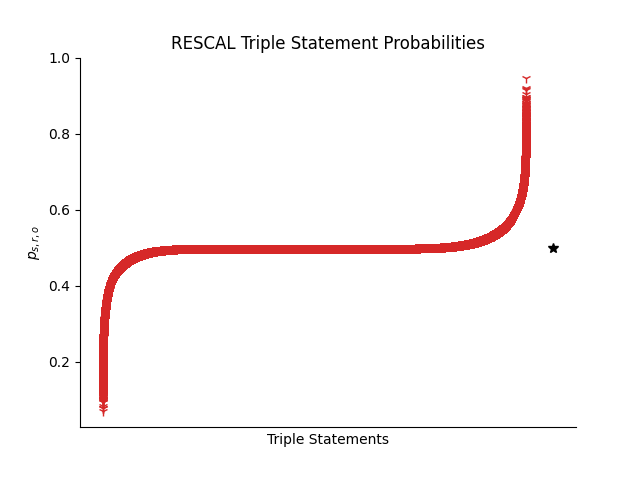

In [5]:
RESCAL_model = torch.load("models/RESCAL.pt")
draw_plot(RESCAL_model, "RESCAL")

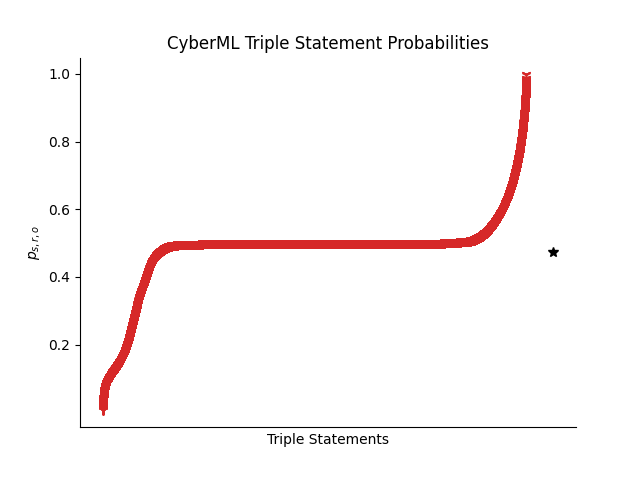

In [6]:
energy_model = torch.load("models/energy.pt")
draw_plot(energy_model, "CyberML")

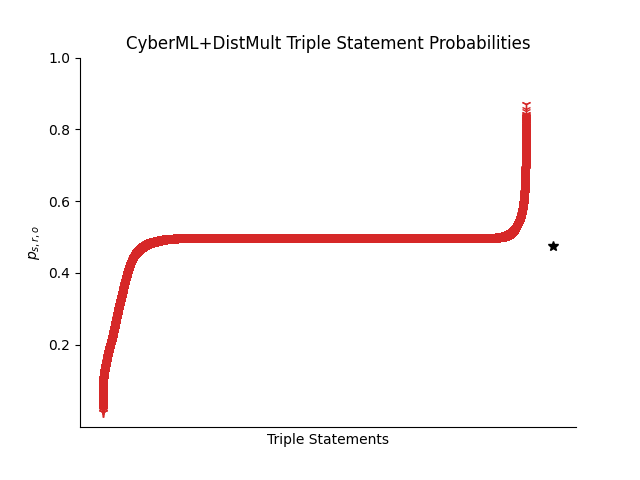

In [7]:
energy_diag_model = torch.load("models/energy_diag.pt")
draw_plot(energy_diag_model, "CyberML+DistMult")